# Ford GoBike System Data
## by Amr Yasser

## Investigation Overview
In this analysis, user characteristics will be explored to determine if they have an effect on the trip duration or distance, the main focus is on age, gender, and user type.

## Dataset Overview
There are originally 183412 trips for the Ford Go Bike in the dataset, and after removing inconsistant and missing data we are left with 174952 trips with their associated information:
- Trip start and end location (by station name)
- Trip distance in meters
- Trip start and end time stamp and total duration in seconds
- User gender (Male, Female or Other)
- User birth year
- Service type (Subscriber or Customer)

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline

FILE_NAME = '201902-fordgobike-tripdata.csv'
df = pd.read_csv(FILE_NAME)

### Wrangling

**1. Convert Lat and Long to distances**


In [2]:
# function to take lat and long and convert them into meters
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

def geo_to_dis(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance*1000

# Apply the geo_to_dis on each row in the datframe
df['distance_m'] = df.apply(lambda x: geo_to_dis(x['start_station_latitude'],
                            x['start_station_longitude'],
                            x['end_station_latitude'],
                            x['end_station_longitude']), axis=1)

**2. Remove unnecessery columns**

In [3]:
remove_columns = ['start_station_id', 'start_station_latitude', 'start_station_longitude',
                   'end_station_id', 'end_station_latitude', 'end_station_longitude',
                   'bike_share_for_all_trip']
df.drop(columns=remove_columns, inplace=True, errors='ignore')

**3. Change Column Typpes**

In [4]:
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

**4. Drop null values**  
null values compromise less than 5% of the data, it's safe to drop them

In [5]:
df.dropna(inplace=True)

**5. Add age column**

In [6]:
df['age'] = 2019 - df.member_birth_year
df = df[df.age<80]

### Duration Distribution

When plotted on the log scale, The duration follows a clear uniform distribution, with some extreme outliers on the right side.  
Most of the trips made take around 500 seconds (~8 minutes).  
Very few trip taken take more than 18000 seconds (300 minutes).

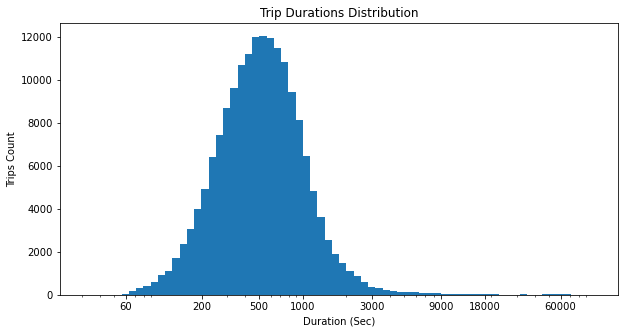

In [7]:
# bin size and edges for the log scale hist
bin_size = 0.05
bins_log = np.arange(1.5, 5+bin_size, bin_size)
# X-axe tick in log scale and values in seconds
x_values = [60, 200, 500, 1000, 3000, 9000, 18000, 60000]
x_ticks = x_values
# Changing scale to log to better vissualize the hist
plt.figure(figsize=[10, 5])
plt.hist(data = df, x = 'duration_sec', bins = 10 ** bins_log)
plt.xscale('log')
plt.xticks(x_ticks, x_values)
plt.title('Trip Durations Distribution')
plt.xlabel('Duration (Sec)')
plt.ylabel('Trips Count')
plt.show()

### Distance Distribution

Most of the data are below 6000 meter. So, focusing the analysis only on distances below the 6000 meters.  
The distance follow a unimodel distribution with a peak around the 800 meters.  

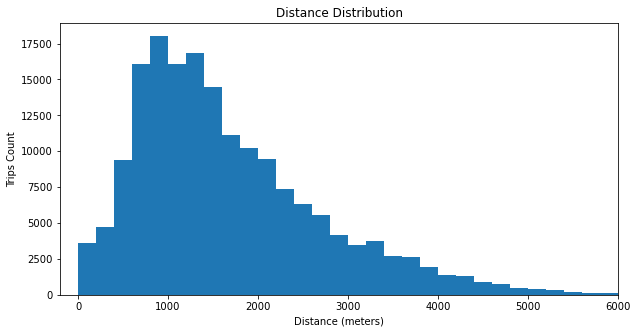

In [8]:
bin_edges = np.arange(0, df.distance_m.max()+200, 200)
plt.figure(figsize=(10,5))
plt.hist(data=df, x='distance_m', bins = bin_edges);
plt.xlim(-200,6000);
plt.title('Distance Distribution')
plt.xlabel('Distance (meters)')
plt.ylabel('Trips Count')
plt.show()

### Trip starting hours

Starting hour takes a bimodel distribution with two clear peaks around the 8 O'cloc and 17 O'cloc (5 pm)  
Before the first peak the slope is very steep starting from 4 O'clock.  
After the second peake a moderate decresing slope ends at 2 O'clock, with a very few number of trips between 2 O'clock and 4 O'clock

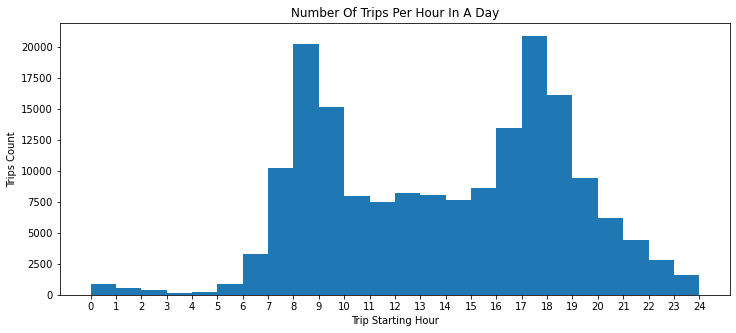

In [9]:
# extracting the starting and ending hour from the column start_time
df['start_hour'] = df.apply(lambda x: x.start_time.hour, axis=1)
df['end_hour'] = df.apply(lambda x: x.end_time.hour, axis=1)
# plotting a hist for the starting hour
plt.figure(figsize=(12,5))
bin_edges = np.arange(0, 25, 1)
plt.hist(x=df['start_hour'], bins=bin_edges)
plt.xlabel('Trip Starting Hour')
plt.xticks(bin_edges)
plt.ylabel('Trips Count')
plt.title('Number Of Trips Per Hour In A Day')
plt.show()

### Gender and User Type Distribution

In [10]:
# getting genders and their percentages of the overall
sorted_genders = df.member_gender.value_counts()
genders = [x for x in sorted_genders.index]
percentages = [x * 100/ df.member_gender.count() for x in sorted_genders.values]
# generating labels from the genders and %
gen_labels = ['{}: {:1.1f}%'.format(x, y) for (x, y) in zip(genders, percentages)]
# getting types and their percentages of the overall
types_values = df.user_type.value_counts()
types = [x for x in types_values.index]
percentages = [x * 100/ df.user_type.count() for x in types_values.values]
# generating labels from the types and %
typ_labels = ['{}: {:1.1f}%'.format(x, y) for (x, y) in zip(types, percentages)]

Almost 75% of trips are made by males.  
About 23% of the trips are made by females.  
And the rest 2% are made by other genders.

More tha 90% of the users are subscribers, and less than 10% are customers

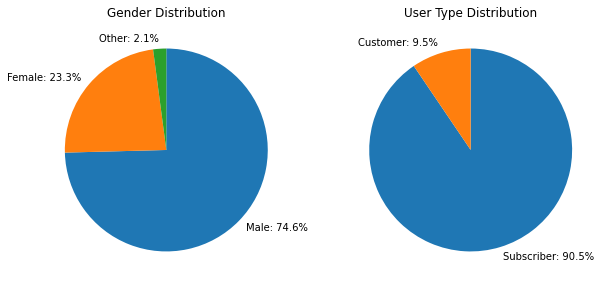

In [11]:
# plot a pie chart for genders
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.pie(df.member_gender.value_counts(), labels=gen_labels, startangle=90, counterclock=False)
plt.title('Gender Distribution')

plt.subplot(1,2,2)
# plot a pie chart for genders
plt.pie(df.user_type.value_counts(), labels=typ_labels, startangle=90, counterclock=False)
plt.title('User Type Distribution')
plt.show()

### Age Distribution

Age larger than 80 is most likely an input error, so we focus only on age less than 80 years  
Most trips are made by users aged 32 and 27 year old.  
Very few users are above 65 years, or below 20 years.

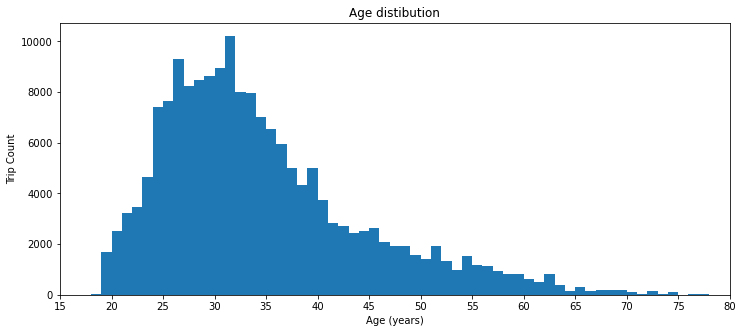

In [12]:
bin_age = np.arange(15, 145, 1)
x_ticks = np.arange(15, 145, 5)
plt.figure(figsize=(12,5))
plt.hist(x=df.age, bins=bin_age);
plt.xticks(x_ticks);
plt.xlim(15,80);
plt.title('Age distibution');
plt.xlabel('Age (years)');
plt.ylabel('Trip Count');

## Bivariate Exploration

### Age and Duration

Most of the long trips with duration > 400 minutes are made by people under 55.  

Except for a couple of points, all trips taking more than 1000 minutes are by people between 20 and 45 years old

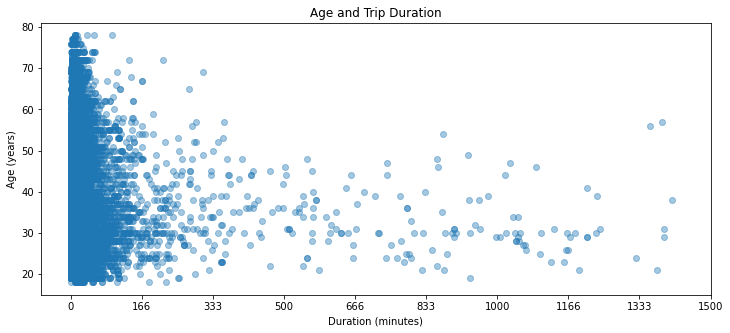

In [13]:
duration_ticks = np.arange(0, df.duration_sec.max() + 10000, 10000)
duration_labels = [int(i) for i in (duration_ticks / 60)]
plt.figure(figsize=(12,5))
plt.scatter(data=df, y='age', x='duration_sec', alpha=0.4);
plt.title('Age and Trip Duration');
plt.ylabel('Age (years)');
plt.xlabel('Duration (minutes)');
plt.xticks(duration_ticks, duration_labels);

### Age and Starting Hour

Starting hour has two clear peaks around the 8 O'cloc and 17 O'cloc (5 pm), which represent the start and end of a work day.  

Most trips taken on those hours (8 a.m and 5 p.m) are made by 30 years old users.  
People in their early 20s have no clear prefrence for the trip timing.

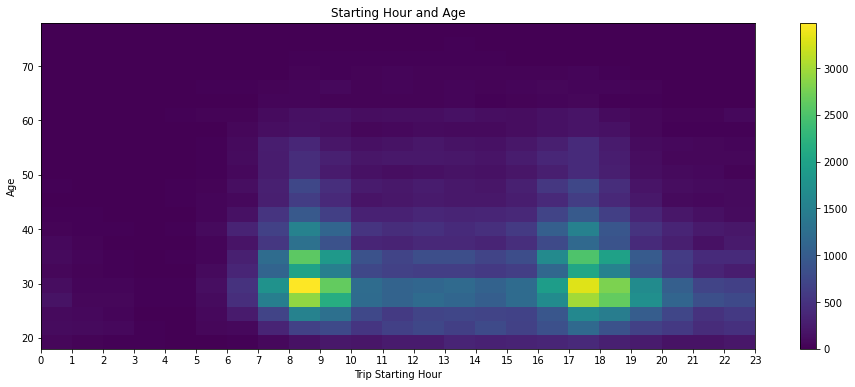

In [14]:
x_ticks = np.arange(0, 24, 1)
plt.figure(figsize=(16,6))
plt.hist2d(data = df, x = 'start_hour', y = 'age', bins=23);
plt.colorbar();
plt.xticks(x_ticks, x_ticks);
plt.xlabel('Trip Starting Hour');
plt.ylabel('Age');
plt.title('Starting Hour and Age');

## Multivariate Exploration

### Gender vs duration and distance

Overall trip duration and distance are very close when comparing by gender  

Most of the long distance trips seem to be done by males, but they also take short distance trips more than others. This could affect the mean to be same as the other two genders.  

With some exceptions, most of the others gender have lower trip duration and distances.

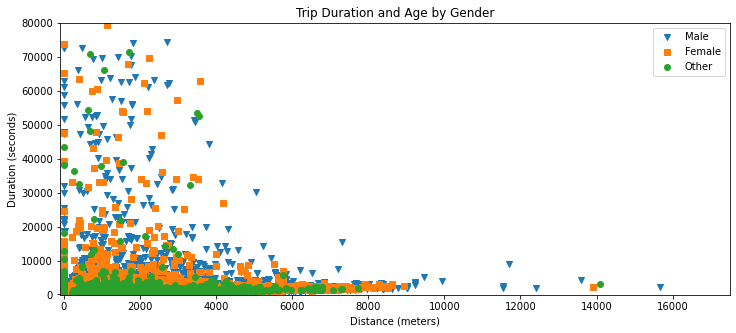

In [15]:
mark_gender = [['Male', 'v'],['Female', 's'],['Other', 'o']]
plt.figure(figsize=(12,5))
for gender, marker in mark_gender:
    df_gender = df[df.member_gender == gender]
    plt.scatter((df_gender.distance_m), df_gender.duration_sec, marker = marker, alpha= 1)
plt.legend(['Male','Female','Other'])
plt.title('Trip Duration and Age by Gender')
plt.xlabel('Distance (meters)')
plt.ylabel('Duration (seconds)')
plt.ylim(-100,80000)
plt.xlim(-100,17500)
plt.show()

### Focusing on User Type and Gender vs Duration

When further studying the duration after the previous scatter plot, it's clear that others gender on average have longer duration trips than males and females, which was not clear from the scatter plot due to a lot of variation in the data. 

Generally all subscribers have shorter average duration than customers

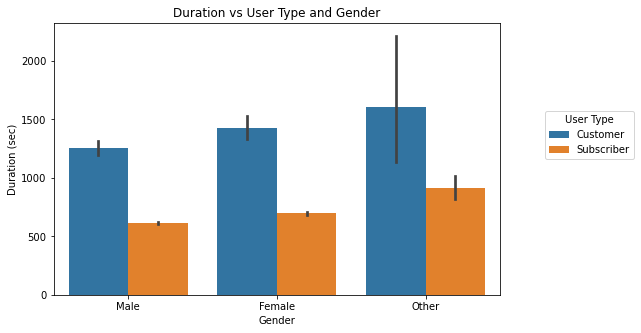

In [16]:
plt.figure(figsize=(8,5))
sb.barplot(data=df, x='member_gender', y='duration_sec', hue='user_type', order=['Male', 'Female', 'Other'])
plt.title('Duration vs User Type and Gender')
plt.xlabel('Gender')
plt.ylabel('Duration (sec)')
plt.legend(title='User Type', loc=(1.1,.5))
plt.show()

### Focusing on User Type and Gender vs Distance

As expected from the previous scatter plot, Gender have no clear winner when comparing distances.  

Same as the duration, average customer have longer distance trips compared to subscribers. Also, the deviations in the other genders are larger than males and females.

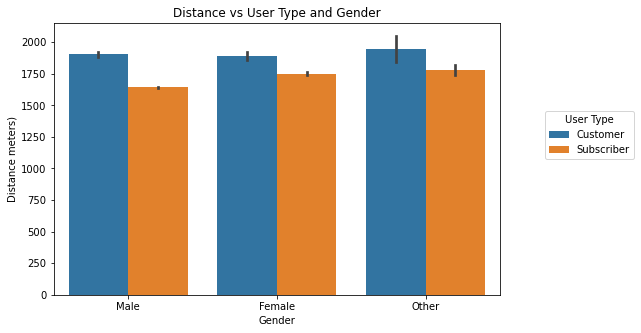

In [17]:
plt.figure(figsize=(8,5))
sb.barplot(data=df, x='member_gender', y='distance_m', hue='user_type', order=['Male', 'Female', 'Other'])
plt.title('Distance vs User Type and Gender')
plt.xlabel('Gender')
plt.ylabel('Distance meters)')
plt.legend(title='User Type', loc=(1.1,.5))
plt.show()